<a href="https://colab.research.google.com/github/beruscoder/architectures/blob/main/ResNetscratch_transferlearning_finetuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: janstylewis7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification


100%|██████████| 401M/401M [00:03<00:00, 116MB/s] 


In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import os
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import image_dataset_from_directory
from keras.utils import plot_model
from tensorflow.keras.layers import Rescaling


from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, auc

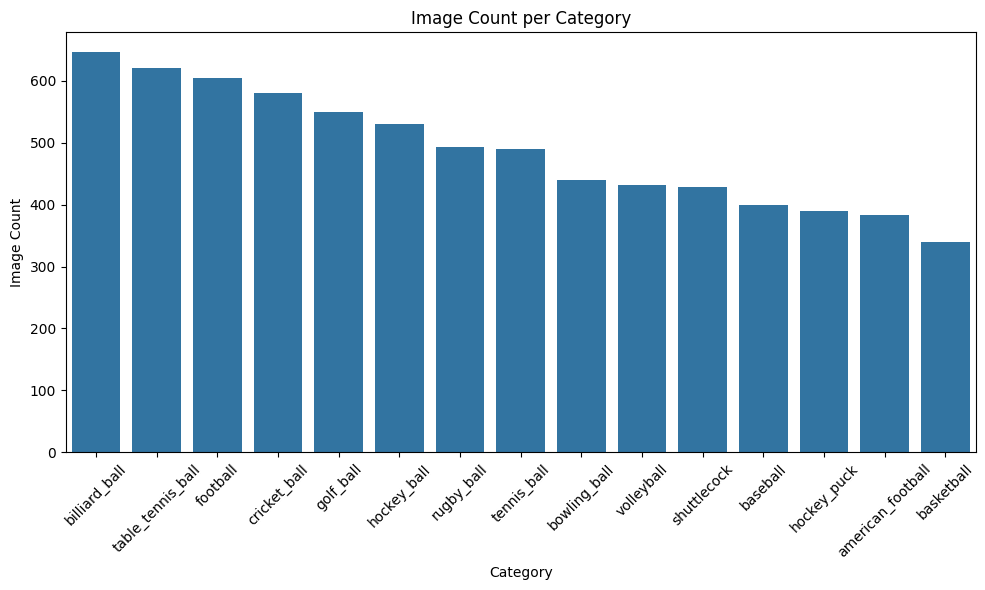

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_dir = "/content/sports-balls-multiclass-image-classification/train"

data = {'category': [], 'image_count': []}

for sub in os.listdir(train_dir):
    sub_dir = os.path.join(train_dir, sub)

    if os.path.isdir(sub_dir):

        num_files = len([
            f for f in os.listdir(sub_dir)
            if os.path.isfile(os.path.join(sub_dir, f))
        ])

        data['category'].append(sub)
        data['image_count'].append(num_files)

df = pd.DataFrame(data)

df = df.sort_values(by='image_count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='category', y='image_count', data=df)
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.title('Image Count per Category')
plt.tight_layout()
plt.show()


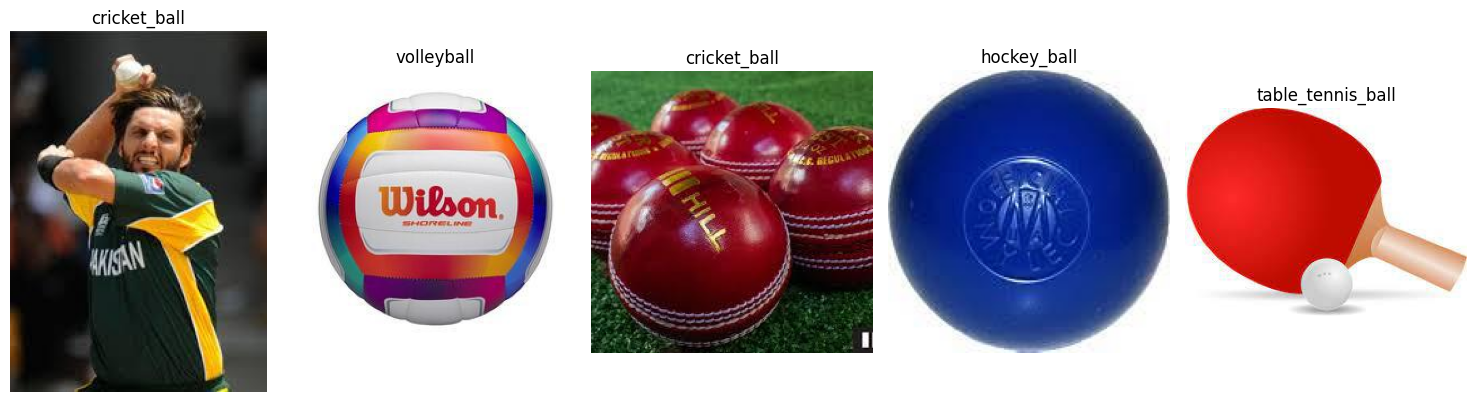

In [4]:
import matplotlib.image as mpimg
num_samples = 5

# Collect all image paths
image_paths = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            if os.path.isfile(fpath) and fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append((fpath, class_name))  # keep path + label

# Randomly select images
samples = random.sample(image_paths, num_samples)

# Plot
plt.figure(figsize=(15, 4))
for i, (img_path, label) in enumerate(samples):
    img = mpimg.imread(img_path)
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [5]:
#hperparameter
img_size = (224,224)
batch_size = 32

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [6]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    labels = 'inferred',
    label_mode = 'categorical',
    validation_split = 0.2,
    subset = "training",
    seed = 123
)


Found 7328 files belonging to 15 classes.
Using 5863 files for training.


In [7]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    labels = 'inferred',
    label_mode = 'categorical',
    subset = "validation",
    validation_split = 0.2,
    seed = 123
)



Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [8]:
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

In [9]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=(3, 3), strides=1):
        super().__init__()
        self.strides = strides
        self.filters = filters
        self.conv1 = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.act1 = layers.ReLU()

        self.conv2 = layers.Conv2D(filters, kernel_size, strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()
        self.act2 = layers.ReLU()

        self.conv3 = layers.Conv2D(filters * 4, kernel_size=1, strides=1, padding='same')
        self.bn3 = layers.BatchNormalization()

        self.shortcut_conv = None
        self.shortcut_bn = None

    def build(self, input_shape):
        if self.strides != 1 or input_shape[-1] != self.filters * 4:
            self.shortcut_conv = layers.Conv2D(self.filters * 4, kernel_size=1, strides=self.strides, padding='same')
            self.shortcut_bn = layers.BatchNormalization()

    def call(self, inputs, training=False):
        shortcut = inputs

        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.bn3(x, training=training)

        if self.shortcut_conv:
            shortcut = self.shortcut_conv(shortcut)
            shortcut = self.shortcut_bn(shortcut, training=training)

        x = layers.Add()([x, shortcut])
        x = tf.nn.relu(x)
        return x


In [10]:
def build_resnet50(input_shape=(224, 224, 3), num_classes=15):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)
    x = ResidualBlock(64)(x)

    x = ResidualBlock(128, strides=2)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)
    x = ResidualBlock(128)(x)

    x = ResidualBlock(256, strides=2)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)
    x = ResidualBlock(256)(x)

    x = ResidualBlock(512, strides=2)(x)
    x = ResidualBlock(512)(x)
    x = ResidualBlock(512)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=x)
    return model


In [11]:
model = build_resnet50(input_shape=(224,224,3), num_classes=15)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block (ResidualBlock)  │ (None, 56, 56, 256)    │       109,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_1                │ (None, 56, 56, 256)    │       202,624 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_2                │ (None, 56, 56, 256)    │       202,624 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_3                │ (None, 28, 28, 512)    │       645,376 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_4                │ (None, 28, 28, 512)    │       806,656 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_5                │ (None, 28, 28, 512)    │       806,656 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_6                │ (None, 28, 28, 512)    │       806,656 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_7                │ (None, 14, 14, 1024)   │     2,568,704 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_8                │ (None, 14, 14, 1024)   │     3,218,944 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_9                │ (None, 14, 14, 1024)   │     3,218,944 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_10               │ (None, 14, 14, 1024)   │     3,218,944 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_11               │ (None, 14, 14, 1024)   │     3,218,944 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_12               │ (None, 14, 14, 1024)   │     3,218,94

 Total params: 58,254,223 (222.22 MB)

 Trainable params: 58,201,103 (222.02 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [13]:
history = model.fit(
    train_data,
    epochs=5,
    validation_data=validation_data
)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 248s 971ms/step - accuracy: 0.1026 - loss: 3.6113 - val_accuracy: 0.0922 - val_loss: 2.8055
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 183s 738ms/step - accuracy: 0.1723 - loss: 2.6114 - val_accuracy: 0.1918 - val_loss: 2.4924
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 136s 705ms/step - accuracy: 0.2323 - loss: 2.4009 - val_accuracy: 0.2478 - val_loss: 3.4650
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 134s 725ms/step - accuracy: 0.2665 - loss: 2.3297 - val_accuracy: 0.1679 - val_loss: 7.1377
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 151s 773ms/step - accuracy: 0.2783 - loss: 2.2752 - val_accuracy: 0.1235 - val_loss: 4.2859


In [24]:
#pretrain model transfer learning
from tensorflow.keras.applications import ResNet50
basemodel = ResNet50(weights='imagenet',include_top=False, input_shape=(224,224,3))
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [19]:
basemodel.trainable = False

inputs = tf.keras.Input(shape=(224,224,3))

x = layers.Rescaling(1./255)(inputs)

x = basemodel(x, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(15, activation='softmax')(x)

model2 = models.Model(inputs=inputs, outputs=outputs)

model2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,116,111 (92.00 MB)

 Trainable params: 528,399 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [21]:
history2 = model2.fit(
    train_data,
    epochs=5,
    validation_data=validation_data
)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 107s 518ms/step - accuracy: 0.0847 - loss: 2.8399 - val_accuracy: 0.1031 - val_loss: 2.6590
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 126s 459ms/step - accuracy: 0.0953 - loss: 2.6788 - val_accuracy: 0.1195 - val_loss: 2.6095
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 83s 451ms/step - accuracy: 0.1108 - loss: 2.6501 - val_accuracy: 0.1549 - val_loss: 2.6158
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 142s 450ms/step - accuracy: 0.1091 - loss: 2.6335 - val_accuracy: 0.1522 - val_loss: 2.5836
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 83s 451ms/step - accuracy: 0.1279 - loss: 2.6089 - val_accuracy: 0.1775 - val_loss: 2.5767


In [26]:
#layers finetune
basemodel.trainable = True

fine_tune_at = 140

for layer in basemodel.layers[:fine_tune_at]:
  layer.trainable = False

model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

fine_tune_history = model2.fit(
    train_data,
    epochs=5,
    validation_data=validation_data
    )

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 183s 708ms/step - accuracy: 0.2952 - loss: 3.5588 - val_accuracy: 0.0628 - val_loss: 2.6825
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 104s 564ms/step - accuracy: 0.7382 - loss: 0.9032 - val_accuracy: 0.1666 - val_loss: 2.5527
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 142s 566ms/step - accuracy: 0.8151 - loss: 0.6188 - val_accuracy: 0.4703 - val_loss: 1.7759
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 143s 572ms/step - accuracy: 0.8556 - loss: 0.4660 - val_accuracy: 0.7256 - val_loss: 1.0037
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 138s 551ms/step - accuracy: 0.8841 - loss: 0.3940 - val_accuracy: 0.7939 - val_loss: 0.7749
